In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.fft import fft, fftfreq
from numba.experimental import jitclass
from numba import njit
from numba import int64, float64
import time

In [2]:
spec = [
    ('w0', float64), 
    ('a', float64[:]),
    ('M', int64),  
    ('k', int64),  
    ('T2', float64),  
]

@jitclass(spec)
class UniformSamp:
    def __init__(self, w0, T2=np.inf):
        self.w0 = w0
        self.a = np.array([1/w0])
        self.M = 1
        self.k = 0
        self.T2 = T2

    
    def iterate(self, d, dk=1):
        a_old = self.a
        self.k = self.k + dk
        self.a = np.append(self.a, np.zeros(self.k))/2

        
        self.a[self.k] += np.exp(-(self.k*np.pi/(self.T2*self.w0))**2)*(-1)**d*a_old[0]/2
        for q in range(1, self.M):
            
            self.a[q+self.k] += np.exp(-(self.k*np.pi/(self.T2*self.w0))**2)*(-1)**d*a_old[q]/4
            self.a[abs(q-self.k)] += np.exp(-(self.k*np.pi/(self.T2*self.w0))**2)*(-1)**d*a_old[q]/4
        
            
        self.M = self.a.shape[0]
        self.a /= self.w0*self.a[0]
        
    
    
    
    def var(self):
        return self.w0/3 + np.array([2*self.a[q]*self.w0*(-1)**q/(q*np.pi)**2 for q in range(1,len(self.a))]).sum(dtype=np.float64) \
            - (1/2 + np.array([self.a[q]*((-1)**q-1)/(q*np.pi)**2 for q in range(1,len(self.a))]).sum(dtype=np.float64))**2

    def stdev(self):
        return np.sqrt(self.var())
    
    def expect(self):
        return 1/2 + np.array([self.a[q]*((-1)**q-1)/(q*np.pi)**2 for q in range(1,len(self.a))]).sum(dtype=np.float64)
    
    def reset(self, w0, T2=np.inf, noise=1):
        self.w0 = w0
        self.a = np.array([1/w0])
        self.M = 1
        self.k = 0
        self.T2 = T2

@njit()       
def FID(true_w, t, T2):

    # Simulate measurement
    p0 = (1 + np.exp(-(t/T2)**2)*np.cos(true_w*t))/2
    draw = np.random.uniform(0,1)
    d = int(draw > p0)
    
    return d

In [3]:
T2 = np.inf

n_loops = 50
n_reps = 10000

data = np.zeros((2, n_reps, n_loops))

ex = UniformSamp(1, T2)



@njit(fastmath=False)
def loop(ex, n_loops, n_reps, T2, data):
    
    i = 0
    while i < n_reps:
        

        true_w = abs(np.random.normal(loc=0, scale=0.5))
        
        if i in [n_reps//10*k for k in range(1, 10)]:
            print(round(100*i/n_reps), "% completed")
            
        ex.reset(1, T2)
        for j in range(1,n_loops+1):
            d = FID(true_w, j*np.pi, T2)
            
            ex.iterate(d)
            
            data[0,i,j-1] = ex.var()
            data[1,i,j-1] = abs(ex.expect()-true_w)
            
        i += 1
    
    return data



start = time.time()

data = loop(ex, n_loops, n_reps, T2, data)

end = time.time()

print()
print('Time elapsed:', end-start, 'seconds')

10 % completed
20 % completed
30 % completed
40 % completed
50 % completed
60 % completed
70 % completed
80 % completed
90 % completed

Time elapsed: 14.957791805267334 seconds


/tmp/ipykernel_1150864/3859218605.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


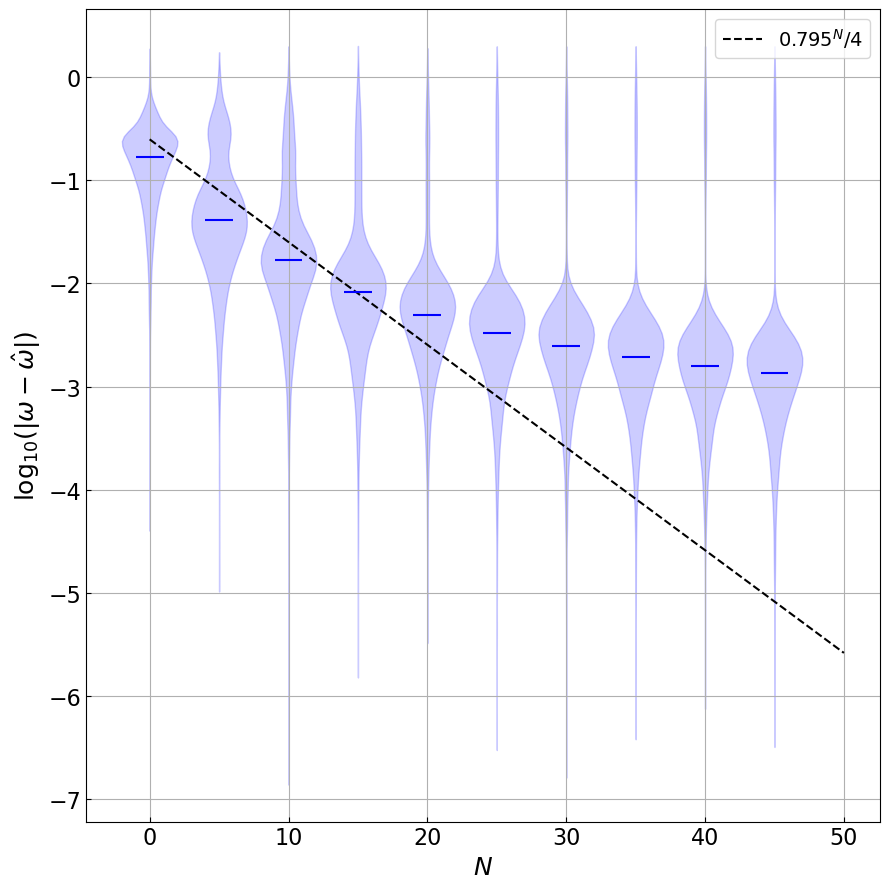

In [4]:
fig, ax1 = plt.subplots(1,1,figsize=(9,9))

# "Linear" guide to the eye (log of an exponential function)
plt.plot(np.arange(51), np.log10(0.25*0.632**(np.arange(51)/2)), ls='--', color='k', label=r'$0.795^{N}/4$')

violin_parts = ax1.violinplot(np.log10(data[1,:,0::5]), 
                              positions=np.arange(50)[0::5], widths=4, showmedians=True, 
                              showextrema=False, showmeans=False, points=100)
for vp in violin_parts['bodies']:
    vp.set_color('blue')
    vp.set_alpha(0.2)
violin_parts['cmedians'].set_color('blue')


ax1.tick_params(labelsize=16, direction='in')
ax1.set_xlabel(r'$N$', fontsize=18)
ax1.set_ylabel(r'$\log_{10}(|\omega-\hat{\omega}|)$', fontsize=18)
ax1.grid()
ax1.legend(fontsize=14)
fig.tight_layout()
fig.show()